# 아파트 실거래가 예측

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')

## Data Load

In [70]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
park_df = pd.read_csv('./input/park.csv')
center_df = pd.read_csv('./input/day_care_center.csv')

In [71]:
train_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

## EDA
### Train and Test set

In [72]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없음
- 1961년 ~ 2017년 완공 건물
- 9.26m^2 ~ 424.32m^2 전용면적
- Floor의 경우 음의 값 존재.
- 실거래가는 100만원부터 820억까지 존재

In [74]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


#### Price

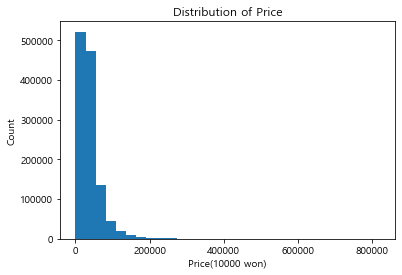

In [75]:
# train price
plt.figure()
plt.hist(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.ylabel('Count')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있음
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있음
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

#### Area

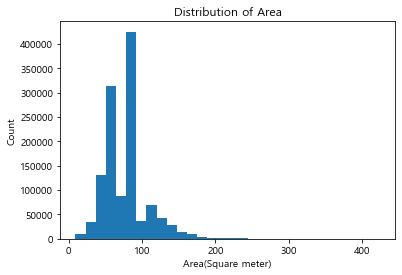

In [76]:
# train area
plt.figure()
plt.hist(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.ylabel('Count')
plt.title('Distribution of Area')
plt.show()

- 면적도 마찬가지로 정규화

#### What is Underground Floor ?

In [77]:
under_floor = train_df.loc[train_df['floor']<0]
print(f'총 {under_floor.shape[0]}개의 음수 층 있음')
print(under_floor['floor'].value_counts())

총 168개의 음수 층 있음
-1    140
-2     17
-3      7
-4      4
Name: floor, dtype: int64


- 168개의 지하층이 존재함

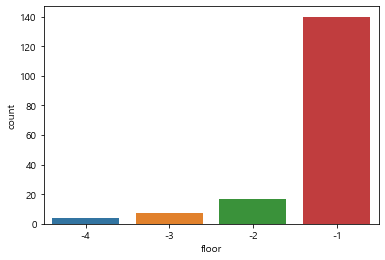

In [78]:
plt.figure()
sns.countplot(under_floor['floor'])
plt.title('')
plt.show()

In [79]:
under_floor[['floor', 'transaction_real_price']].corr()

,floor,transaction_real_price
floor,1.000000,-0.126958
transaction_real_price,-0.126958,1.000000


층수와 가격간의 선형 설명력이 어느정도 존재하기 때문에 제거하지 않는다.

In [80]:
test_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,1179897,11086,서울특별시,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,1223091,2121,부산광역시,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


In [81]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


- test셋에도 널값은 존재하지 않음.
- 실거래가 변수 없음(타겟 변수)
- 완공연도 1961년부터 2017년
- 실거래연도는 2017년도만 존재함
- 전용면적은 10.32m^2부터 273.86m^2까지 존재

### Park Data

In [83]:
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


- 시설에 매우 많은 결측치가 존재함
- 시설이 존재하면 1 없으면 0으로 값 대체


#### Null Data Replace

In [84]:
park_df.iloc[:,6:11] = park_df.iloc[:,6:11].notnull().astype(int)
park_df

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,0,0,0,0,0,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,0,0,0,0,0,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,0,0,0,0,0,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,0,0,0,0,0,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,0,0,0,0,0,1970.0,2018-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,서울특별시,구로구,천왕동,이펜시아어린이공원,어린이공원,1500.0,0,1,0,0,0,2006.0,2019-02-25
1355,서울특별시,구로구,천왕동,개명소공원,소공원,5415.0,0,0,0,0,0,2006.0,2019-02-25
1356,서울특별시,구로구,천왕동,봉화대근린공원,근린공원,60975.0,0,0,0,0,0,2006.0,2019-02-25
1357,서울특별시,구로구,항동,푸른수목원,근린공원,100809.0,0,0,0,0,0,2005.0,2019-02-25


#### Park Area

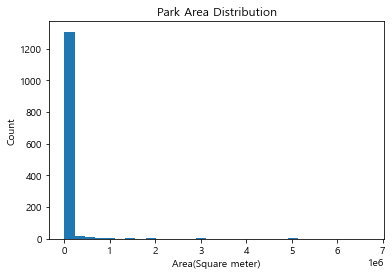

In [103]:
plt.figure()
plt.hist(park_df['park_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.ylabel('Count')
plt.title('Park Area Distribution')
plt.show()

- 분포가 매우 왼쪽으로 치우친 형태
- 공원 면적이 집 값에 영향을 미치는가?

#### Facility Correlation 

Text(0.5, 1.0, 'Facility Corr. Heatmap')

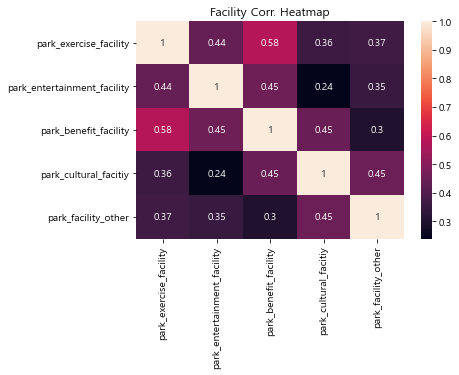

In [86]:
facility = park_df.iloc[:,6:11]
plt.figure()
sns.heatmap(facility.corr(), annot=True)
plt.title('Facility Corr. Heatmap')

- 어느정도 관계는 있으나 다중공선성은 없다고 판단됨.

### Center

In [87]:
center_df.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


In [88]:
center_df.describe()

,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num
count,7551.000000,7326.000000,4352.000000,3626.000000,5280.000000
mean,44.396636,9.013514,4.528033,0.398235,6.676136
std,37.022079,5.809909,2.075709,0.730602,4.482168
min,5.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,6.000000,3.000000,0.000000,4.000000
50%,29.000000,7.000000,4.000000,0.000000,5.000000
75%,60.000000,11.000000,5.000000,1.000000,8.000000
max,489.000000,98.000000,22.000000,16.000000,53.000000


In [105]:
center_df.isna().sum()

city                       0
gu                         0
day_care_name              0
day_care_type              0
day_care_baby_num          0
teacher_num              225
nursing_room_num        3199
playground_num          3925
CCTV_num                2271
is_commuting_vehicle     496
reference_date             0
dtype: int64

In [90]:
center_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  7551 non-null   object 
 1   gu                    7551 non-null   object 
 2   day_care_name         7551 non-null   object 
 3   day_care_type         7551 non-null   object 
 4   day_care_baby_num     7551 non-null   int64  
 5   teacher_num           7326 non-null   float64
 6   nursing_room_num      4352 non-null   float64
 7   playground_num        3626 non-null   float64
 8   CCTV_num              5280 non-null   float64
 9   is_commuting_vehicle  7055 non-null   object 
 10  reference_date        7551 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 649.0+ KB


In [91]:
center_df['is_commuting_vehicle'].value_counts()

N    4102
Y    2446
      401
y      88
n      18
Name: is_commuting_vehicle, dtype: int64

In [92]:
center_df.replace('y','Y',inplace=True)
center_df.replace('n','N',inplace=True)

Text(0.5, 1.0, 'Day Care Type Count Plot')

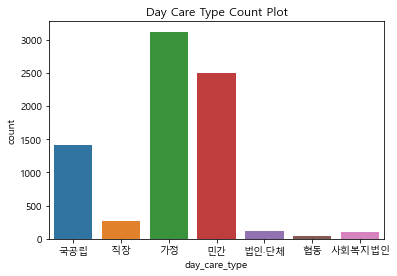

In [93]:
plt.figure()
sns.countplot(center_df['day_care_type'])
plt.title('Day Care Type Count Plot')

In [94]:
pd.DataFrame(center_df.groupby('day_care_type')['day_care_baby_num'].mean()).rename(columns={'day_care_baby_num': 'mean_baby_num'})

,mean_baby_num
day_care_type,
가정,18.394551
국공립,64.024858
민간,60.483949
법인·단체,64.575221
사회복지법인,85.392523
직장,71.334559
협동,29.179487


Text(0.5, 1.0, 'Commuting Vehicle Count Plot')

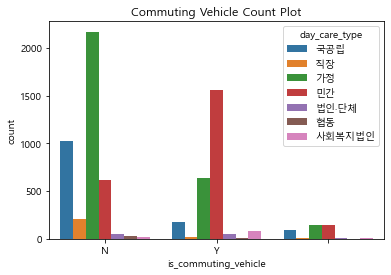

In [95]:
plt.figure()
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.countplot(center_df['is_commuting_vehicle'], hue='day_care_type', data=center_df)
plt.title('Commuting Vehicle Count Plot')

Text(0.5, 0, 'Number of Baby')

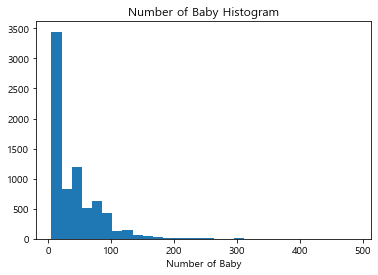

In [96]:
plt.figure()
plt.hist(center_df['day_care_baby_num'], bins=30)
plt.title('Number of Baby Histogram')
plt.xlabel('Number of Baby')

In [97]:
cctv_baby = center_df.groupby('CCTV_num')['day_care_baby_num'].mean()  
cctv_baby

CCTV_num
0.0      26.200000
1.0      22.833333
2.0      25.739130
3.0      18.270335
4.0      22.315408
5.0      31.706468
6.0      43.994764
7.0      52.978261
8.0      57.987234
9.0      71.549383
10.0     73.013072
11.0     76.471545
12.0     82.456522
13.0     80.691358
14.0     89.188406
15.0     86.791045
16.0     97.120482
17.0    128.714286
18.0    110.647059
19.0    120.416667
20.0    137.894737
21.0    123.000000
22.0    134.000000
23.0    123.750000
24.0    161.647059
25.0    175.600000
26.0    177.750000
27.0    200.000000
28.0    140.750000
29.0    153.000000
31.0     94.000000
32.0    165.222222
33.0    200.000000
36.0     88.333333
39.0    195.000000
40.0    280.000000
41.0    200.000000
53.0    222.000000
Name: day_care_baby_num, dtype: float64

Text(0.5, 0, 'Number of CCTV')

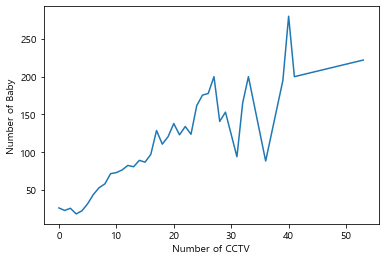

In [98]:
plt.figure()
plt.plot(cctv_baby)
plt.ylabel('Number of Baby')
plt.xlabel('Number of CCTV')

In [99]:
model = smf.ols(formula = 'day_care_baby_num ~ CCTV_num', data = center_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      day_care_baby_num   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     6652.
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:55:17   Log-Likelihood:                -24430.
No. Observations:                5280   AIC:                         4.886e+04
Df Residuals:                    5278   BIC:                         4.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2859      0.611      3.743      0.000       1.089       3.483
CCTV_num       6.1941      0.076     81.561      0.000       6.045       6.343
==============================================================================
Omnibus:                     2679.170   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58677.008
Skew:                           1.935   Prob(JB):                         0.00
Kurtosis:                      18.866   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

국공립과 직장, 가정, 협동,의 경우 N이 많고 민간은 Y가 많으므로 해당 분류에 맞게 결측치를 채우고
나머지 분류는 일반적으로 N이 많으로 N으로 채운다

In [100]:
center_df[['is_commuting_vehicle', 'day_care_baby_num']]

,is_commuting_vehicle,day_care_baby_num
0,N,70
1,N,88
2,N,90
3,N,18
4,N,93
...,...,...
7546,Y,46
7547,Y,19
7548,Y,92
7549,Y,43


In [101]:
center_df['day_care_type'].unique()

array(['국공립', '직장', '가정', '민간', '법인·단체', '협동', '사회복지법인'], dtype=object)

NameError: name 'teacher_baby' is not defined

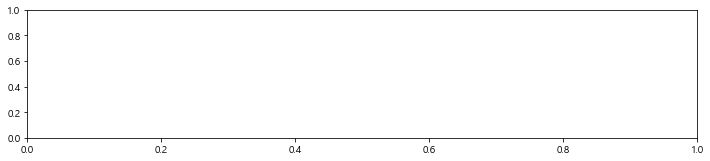

In [102]:
plt.subplots(1,3, figsize=(12,8))

ax1 = plt.subplot(311)
ax1.plot(teacher_baby)
plt.ylabel('Number of Baby')
plt.xlabel('Number of Teacher')

ax2 = plt.subplot(312)
ax2.plot(nursing_baby)
plt.ylabel('Number of Baby')
plt.xlabel('Number of Nursing Room')

ax3 = plt.subplot(313)
ax3.plot(ground_baby)
plt.ylabel('Number of Baby')
plt.xlabel('Number of Playground')

plt.subplots_adjust(hspace=0.3)
plt.show()


In [ ]:
teacher_baby = center_df.groupby('teacher_num')['day_care_baby_num'].mean()
nursing_baby = center_df.groupby('nursing_room_num')['day_care_baby_num'].mean()
ground_baby = center_df.groupby('playground_num')['day_care_baby_num'].mean()

In [ ]:
center_df